In [4]:
from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient, OperatorStateFn
from qiskit.utils import QuantumInstance
import matplotlib.pyplot as plt
import sys, os
sys.path.insert(0, os.path.join("..", "..","src"))
from qiskit_utils import BinaryObjectiveFunction
from data_utils import circle, plot_data, generate_ds
import numpy as np
# Set a random seed
np.random.seed(42)

In [5]:
# Generate training and test data
num_training = 200
num_test = 2000

X_train, y_train, new_y_train = generate_ds(num_training)
X_test, y_test, new_y_test= generate_ds(num_test)

In [6]:
# set method to calculcate expected values
expval = AerPauliExpectation()

# define gradient method
gradient = Gradient()

# define quantum instances (statevector and sample based)
qi_sv = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

In [7]:
from qiskit_machine_learning.neural_networks import OpflowQNN

In [12]:

inputs = ParameterVector('input', length=3) # 1 extra for label
# inputs = ParameterVector('input', length=3)
weights = ParameterVector('weight', length=18)

# 1qubit classifier
qc1 = QuantumCircuit(1)
qc1.u(weights[15],weights[16],weights[17],0)
qc1.rz(inputs[0]*weights[0]+inputs[1]*weights[1]+inputs[2]*weights[2] + weights[3],0)
qc1.ry(weights[4],0)
qc1.rz(inputs[0]*weights[5]+inputs[1]*weights[6]+inputs[2]*weights[7] + weights[8],0)
qc1.ry(weights[9],0)
qc1.rz(inputs[0]*weights[10]+inputs[1]*weights[11]+inputs[2]*weights[12] + weights[13],0)
qc1.ry(weights[14],0)
qc_sfn1 = StateFn(qc1)

H1 = StateFn(PauliSumOp.from_list([('Z', 1.0)]))  
H2 = StateFn(PauliSumOp.from_list([('Z', -1.0)]))  

op1 = ~H1 @ (qc_sfn1)
op2 = ~H2 @ (qc_sfn1)
print(op1)
print(len(weights))

ComposedOp([
  OperatorMeasurement(1.0 * Z),
  CircuitStateFn(
       ┌─────────────────────────────────────┐»
  q_0: ┤ U(weight[15],weight[16],weight[17]) ├»
       └─────────────────────────────────────┘»
  «     ┌──────────────────────────────────────────────────────────────────────────────┐»
  «q_0: ┤ Rz(input[0]*weight[0] + input[1]*weight[1] + input[2]*weight[2] + weight[3]) ├»
  «     └──────────────────────────────────────────────────────────────────────────────┘»
  «     ┌───────────────┐»
  «q_0: ┤ Ry(weight[4]) ├»
  «     └───────────────┘»
  «     ┌──────────────────────────────────────────────────────────────────────────────┐»
  «q_0: ┤ Rz(input[0]*weight[5] + input[1]*weight[6] + input[2]*weight[7] + weight[8]) ├»
  «     └──────────────────────────────────────────────────────────────────────────────┘»
  «     ┌───────────────┐»
  «q_0: ┤ Ry(weight[9]) ├»
  «     └───────────────┘»
  «     ┌──────────────────────────────────────────────────────────────────────────────────

In [13]:
# construct OpflowQNN with the operator, the input parameters, the weight parameters,
# the expected value, gradient, and quantum instance.
qnn1 = OpflowQNN(op1, inputs, weights, expval, gradient, qi_sv, input_gradients=True)
qnn2 = OpflowQNN(op2, inputs, weights, expval, gradient, qi_sv, input_gradients=True)

In [14]:
from qiskit.algorithms.optimizers import ADAM, L_BFGS_B
from qiskit_machine_learning.utils.loss_functions import L2Loss

losses = []
def callback_fn(avg_loss, weights):
    print("weights: ", weights)
    print("loss: ", avg_loss)
    losses.append(avg_loss)

function = BinaryObjectiveFunction(X_train, new_y_train, qnn1, qnn2, L2Loss(), callback_fn)

In [21]:
losses = []
# optimizer = ADAM(maxiter=30, lr=0.8)
optimizer = L_BFGS_B(maxiter=50)
# fit_result = optimizer.minimize(
fit_result = optimizer.optimize( 
    num_vars=qnn1.num_weights,
    objective_function=function.objective,
    initial_point=algorithm_globals.random.random(qnn1.num_weights),
    gradient_function=function.gradient,
)

print(fit_result)

<bound method BinaryObjectiveFunction.gradient of <__main__.BinaryObjectiveFunction object at 0x000001A41A9DAAF0>>
weights:  [0.91556728 0.99780486 0.59818291 0.45382361 0.49467718 0.63559704
 0.59185242 0.37956106 0.30616228 0.14979807 0.35638856 0.26047166
 0.50701515 0.04486046 0.44137478 0.6516528  0.11396187 0.96128778]
loss:  1.3933291330908693
weights:  [0.47034168 0.7699239  0.59818291 0.50650826 1.0517973  0.20655821
 0.38284653 0.37956106 0.35077633 0.36360475 0.01444878 0.09693094
 0.50701515 0.08327126 0.32945315 0.67955548 0.16664652 0.96128778]
loss:  1.2059566432819693
weights:  [ 0.24171779  0.63366196  0.59818291  0.64412489  1.13528063 -0.01729325
  0.25119142  0.37956106  0.46834144  0.30792037 -0.15494545  0.00401215
  0.50701515  0.15181606  0.13410547  0.53523178  0.30426315  0.96128778]
loss:  1.0107639505977424
weights:  [ 0.11356318  0.53294132  0.59818291  0.71583752  1.18884268 -0.13089704
  0.1637415   0.37956106  0.51725256  0.29391077 -0.23880165 -0.046454

loss:  0.47438832053736335
weights:  [-1.75173603  2.07324598  0.59818291  1.55355359  1.93859566 -1.41171806
  0.32530822  0.37956106  0.04665916  0.56009628 -1.44536785 -1.17157879
  0.50701515 -0.12766658 -1.24998464  0.92020012  1.21369184  0.96128778]
loss:  0.4034593701186705
weights:  [-2.19100483  2.43651146  0.59818291  1.65570927  1.6894283  -1.76112357
  0.79575735  0.37956106 -0.05022418  0.4819243  -1.5893763  -0.83398346
  0.50701515  0.25964696 -1.24921889  1.06863632  1.31584753  0.96128778]
loss:  0.3419057186904804
weights:  [-2.12234087  2.33537996  0.59818291  1.67765417  1.76740087 -1.61267415
  0.71525932  0.37956106 -0.03184463  0.50559152 -1.50732923 -0.9365056
  0.50701515  0.12899498 -1.36048895  0.9498253   1.33779242  0.96128778]
loss:  0.30378565036980604
weights:  [-2.25603755  2.50634414  0.59818291  1.66745462  1.70826937 -1.73212884
  0.85966109  0.37956106 -0.1259464   0.46064967 -1.56780731 -0.95594135
  0.50701515  0.07900906 -1.46587352  0.88623062 

loss:  0.2694141054304836
(array([-0.76749056,  2.15815197,  0.59818291,  1.70805713,  1.02545904,
       -1.82968651,  1.10976533,  0.37956106, -0.07531243,  1.34411933,
       -2.07482092, -0.18508873,  0.50701515,  0.0688704 , -1.66676946,
        1.03647596,  1.36819538,  0.96128778]), 53.88282108609672, 64)


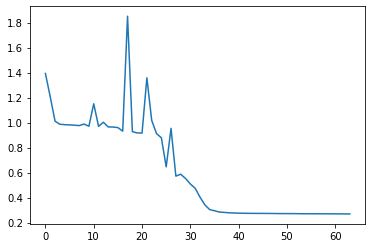

In [22]:
plt.plot(losses)

In [15]:
ws = [-0.76749056,  2.15815197,  0.59818291,  1.70805713,  1.02545904,
       -1.82968651,  1.10976533,  0.37956106, -0.07531243,  1.34411933,
       -2.07482092, -0.18508873,  0.50701515,  0.0688704 , -1.66676946,
        1.03647596,  1.36819538,  0.96128778]

from test_utils import get_metrics
y_predict, y_tensor, accuracy, [tp, tn, fp, fn] = get_metrics(X_train, qnn1, ws)

Accuracy:  0.875
tp:  84 tn:  91  fp:  15  fn:  10


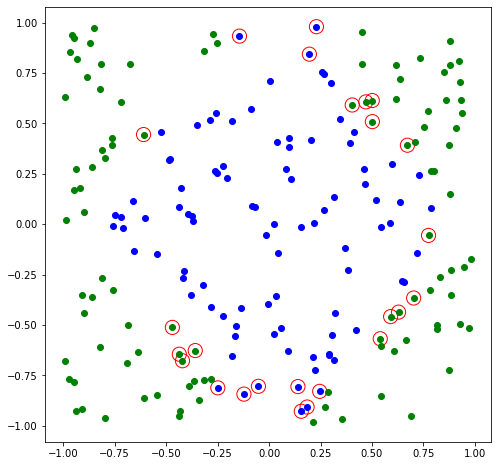

In [16]:
# print('Accuracy:', acc/len(y_tensor))
plt.figure(figsize=(8,8))
for x, y_target, y_ in zip(X_train, y_tensor, y_predict):
    if y_ == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=1)
plt.show()

In [17]:
y_predict, y_tensor, accuracy, [tp, tn, fp, fn] = get_metrics(X_test, qnn1, ws)

Accuracy:  0.8865
tp:  878 tn:  895  fp:  125  fn:  102


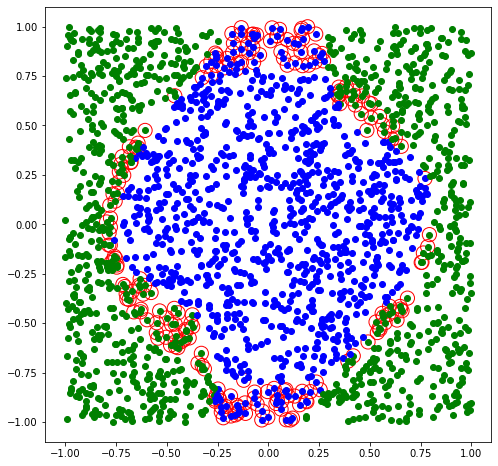

In [18]:
# print('Accuracy:', acc/len(y_tensor))
plt.figure(figsize=(8,8))
for x, y_target, y_ in zip(X_test, y_tensor, y_predict):
    if y_ == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=1)
plt.show()

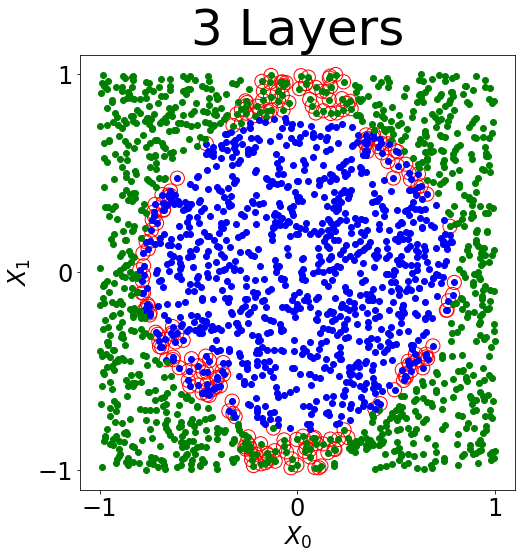

In [19]:
from matplotlib.ticker import MaxNLocator

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

# plot_data(Xdata, y_train, fig=fig, ax=axes[0])
for x, y_target, y_ in zip(X_test, y_tensor, y_predict):
    if y_target == 1:
        axes.plot(x[0], x[1], 'bo')
    else:
        axes.plot(x[0], x[1], 'go')
    if y_target != y_:
        axes.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=1)
        
axes.set_title('3 Layers', fontsize = 50)

axes.xaxis.set_major_locator(MaxNLocator(nbins=2))
axes.yaxis.set_major_locator(MaxNLocator(nbins=2))

axes.tick_params(labelsize=24)
axes.set_box_aspect(1)
axes.set_xlabel("$X_{0}$", fontsize=24)
axes.set_ylabel("$X_{1}$", fontsize=24)

# fig.tight_layout(pad=3.0)
plt.show()